In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss

from xgboost import XGBClassifier

import shap
shap.initjs()


In [122]:
file_path = '../data/data_small.csv'
df = pd.read_csv(file_path, encoding='UTF-8', low_memory=False)
df.shape

(17272, 15)

In [123]:
float_data = [
    'age',
    'BMI',
    'protein_energy_ratio',
    'carbohydrate_energy_ratio',
    'energy'
]
# 'fat_energy_ratio'

In [124]:
categorical_data = [
    'sex',
    'heavy_drink',
    'smoke',
    'genetic_diabetes',
    'Hypercholesterolemia',
    'hypertriglyceridemia',
    'high_bloodpressure',
    'stroke',
    'walking_practice'
]

# 'abdominal_obesity'

In [125]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 선택한 열에 대해 정규화 적합 및 변환
for col in float_data:
    try:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).flatten()
    except KeyError:
        pass
df.head()

,sex,age,heavy_drink,smoke,genetic_diabetes,Hypercholesterolemia,hypertriglyceridemia,high_bloodpressure,stroke,BMI,walking_practice,protein_energy_ratio,carbohydrate_energy_ratio,energy,diabetes
0,1,0.683333,1,0,0,0,0,3,0,0.246797,0,0.257002,0.663757,0.156614,1
1,1,0.133333,0,0,0,0,0,1,0,0.060075,0,0.243481,0.592662,0.150485,0
2,1,0.550000,1,1,0,0,0,2,0,0.119276,0,0.264621,0.672799,0.126264,0
3,2,0.500000,0,0,0,0,0,1,0,0.260036,0,0.278310,0.542170,0.135401,0
4,2,0.850000,0,0,0,0,0,3,0,0.315124,0,0.265598,0.517273,0.137300,0


In [126]:
y = df.diabetes
X = df.drop('diabetes', axis=1)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [128]:
# SMOTE-NC를 적용할 훈련 데이터에 대한 범주형 열의 인덱스 생성
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_data]

# SMOTE-NC 적용
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=0)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# 결과 확인
print("Original training data shape:", X_train.shape, y_train.shape)
print("Resampled training data shape:", X_train_resampled.shape, y_train_resampled.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Original training data shape: (13817, 14) (13817,)
Resampled training data shape: (23040, 14) (23040,)
Test data shape: (3455, 14) (3455,)


In [129]:
X_train = X_train_resampled
y_train = y_train_resampled
# XGBModel = XGBClassifier(tree_method='gpu_hist', gpu_id=0, enable_categorical=True)
XGBModel = XGBClassifier(device='cuda', enable_categorical=True)

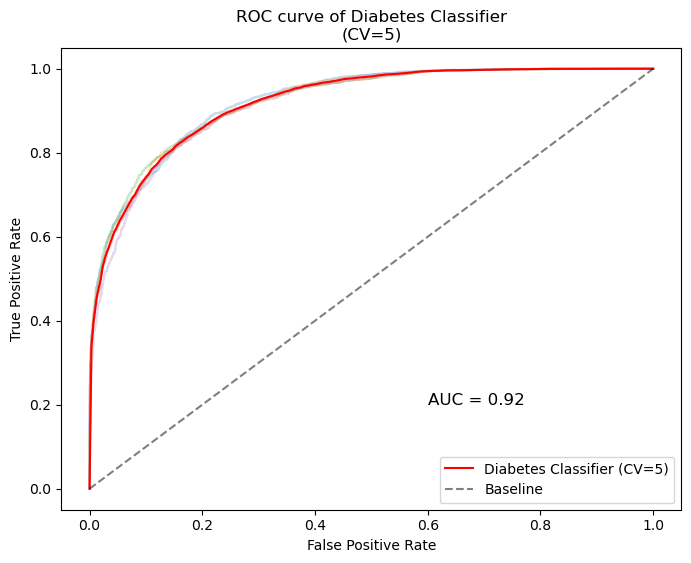

Fold 1 - AUC: 0.92, Accuracy: 0.83, F1 Score: 0.84
Fold 2 - AUC: 0.92, Accuracy: 0.83, F1 Score: 0.83
Fold 3 - AUC: 0.92, Accuracy: 0.83, F1 Score: 0.84
Fold 4 - AUC: 0.92, Accuracy: 0.83, F1 Score: 0.83
Fold 5 - AUC: 0.92, Accuracy: 0.83, F1 Score: 0.83
Mean AUC: 0.92
Mean Accuracy: 0.83
Mean F1 Score: 0.83


In [130]:
# k-fold 검증 코드

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tprs_diabetes = []
base_fpr_diabetes = np.linspace(0, 1, 300)

# 각 fold에서의 AUC, 정확도, F1 점수를 저장할 리스트
auc_scores = []
accuracy_scores = []
f1_scores = []

# 기존 코드와 같이 ROC 곡선을 그리는 부분
plt.figure(figsize=(8, 6))
base_fpr = np.linspace(0, 1, 300)

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    XGBModel.fit(X_train_fold, y_train_fold)
    
    y_val_prob_fold = XGBModel.predict_proba(X_val_fold)[:, 1]
    y_val_pred_fold = XGBModel.predict(X_val_fold)
    
    FPR_fold, TPR_fold, _ = roc_curve(y_val_fold, y_val_prob_fold)
    
    plt.plot(FPR_fold, TPR_fold, alpha=0.25)
    tpr_fold = np.interp(base_fpr_diabetes, FPR_fold, TPR_fold)
    tpr_fold[0] = 0.0
    tprs_diabetes.append(tpr_fold)
    
    # 평가 지표 계산
    auc_score_fold = roc_auc_score(y_val_fold, y_val_prob_fold)
    accuracy_score_fold = accuracy_score(y_val_fold, y_val_pred_fold)
    f1_score_fold = f1_score(y_val_fold, y_val_pred_fold)
    
    # 평가 지표 저장
    auc_scores.append(auc_score_fold)
    accuracy_scores.append(accuracy_score_fold)
    f1_scores.append(f1_score_fold)

# 최종 ROC 곡선 그리기
tprs_diabetes = np.array(tprs_diabetes)
mean_tprs_diabetes = np.mean(tprs_diabetes, axis=0)
mean_tprs_diabetes[-1] = 1.0
mean_auc = np.mean(auc_scores)

plt.plot(base_fpr, mean_tprs_diabetes, label='Diabetes Classifier (CV=5)', color='red')
plt.plot([0, 1], [0, 1], label='Baseline', color='black', linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Diabetes Classifier\n(CV=5)')
plt.legend(loc='lower right')
plt.text(0.6, 0.2, f'AUC = {mean_auc:.2f}', fontsize=12)
plt.show()

# 각 fold의 평가 지표 출력
for i, (auc, acc, f1) in enumerate(zip(auc_scores, accuracy_scores, f1_scores)):
    print(f'Fold {i+1} - AUC: {auc:.2f}, Accuracy: {acc:.2f}, F1 Score: {f1:.2f}')

# 최종 평균 평가 지표 출력
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.2f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.2f}')

In [131]:
# 최종 모델 학습
XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

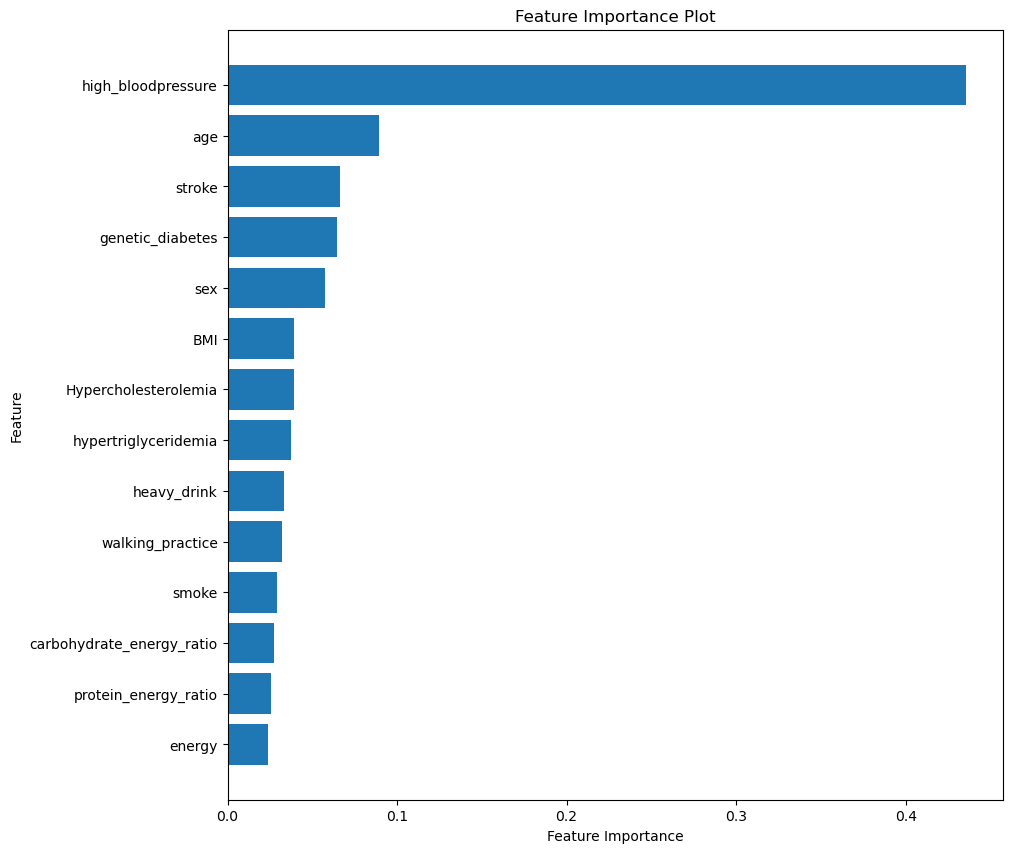

In [132]:
# 변수중요도 확인
importances = XGBModel.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

In [133]:
# shap 분석 시작
explainer = shap.TreeExplainer(XGBModel, X_train)
shap_values = explainer(X_test)
clust = shap.utils.hclust(X_test, y_test, linkage="single")

c:\Users\flinter\anaconda3\Lib\site-packages\shap\utils\_clustering.py:126: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
c:\Users\flinter\anaconda3\Lib\site-packages\shap\utils\_clustering.py:126: UserWarning: No/low signal found from feature 3 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")


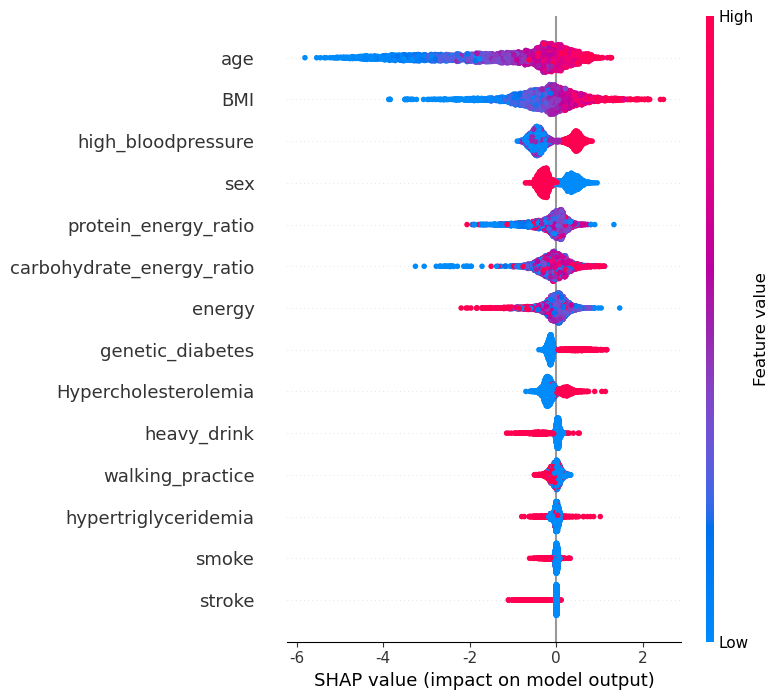

In [134]:
# 모든 피처의 모델 영향력에 대한 해석
shap.summary_plot(shap_values, X_test, max_display=16)

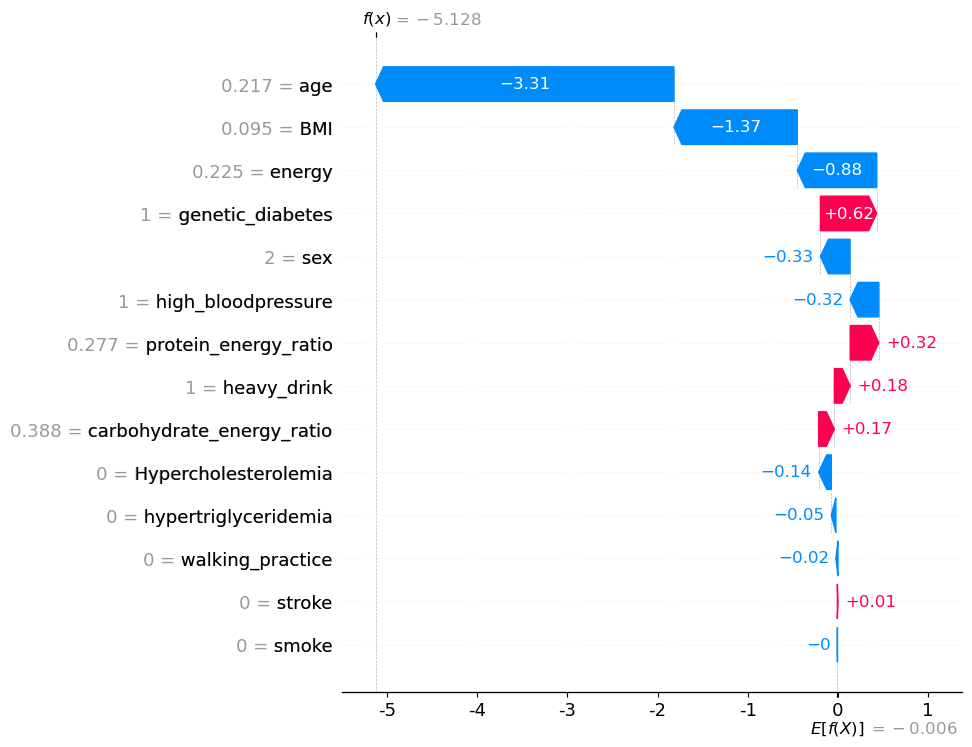

In [135]:
shap.waterfall_plot(shap_values[1], max_display=16)

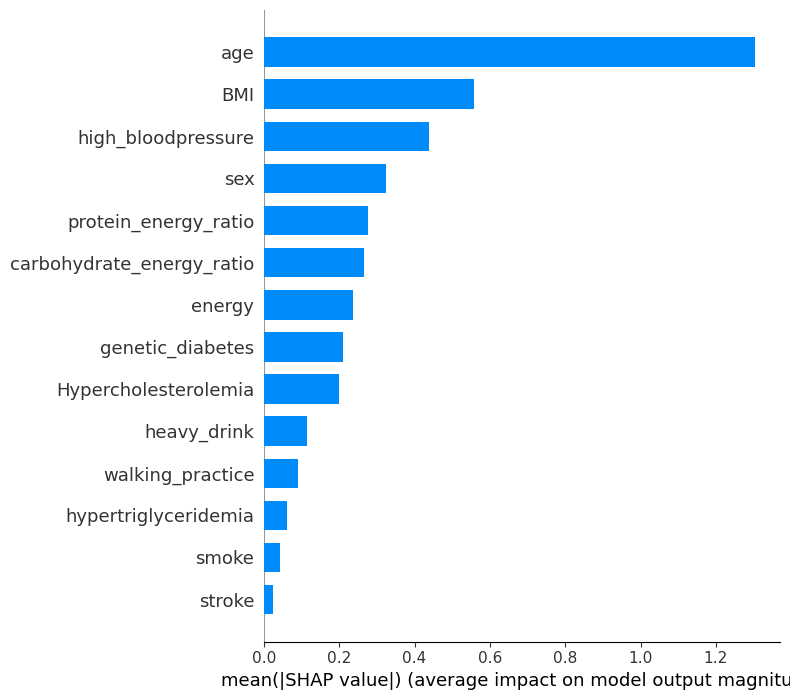

In [136]:
shap.summary_plot(shap_values, X_test, max_display=len(X_test.columns), plot_type='bar')

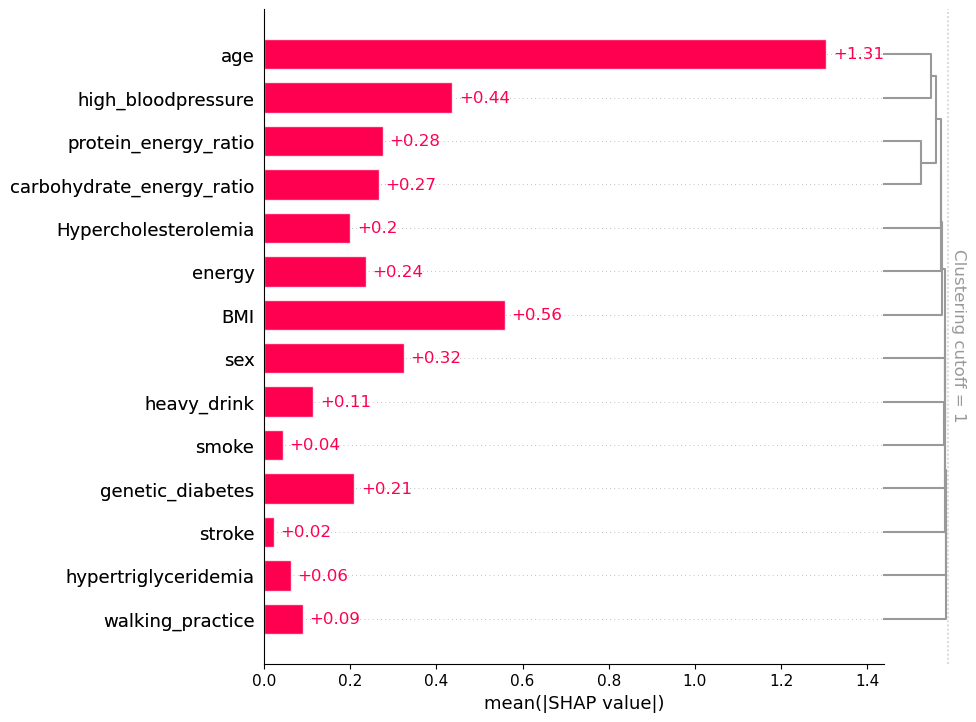

In [137]:
# 모든 피처의 모델 영향력에 대한 해석
shap.plots.bar(shap_values, max_display=len(X_test.columns),clustering=clust, clustering_cutoff=1)

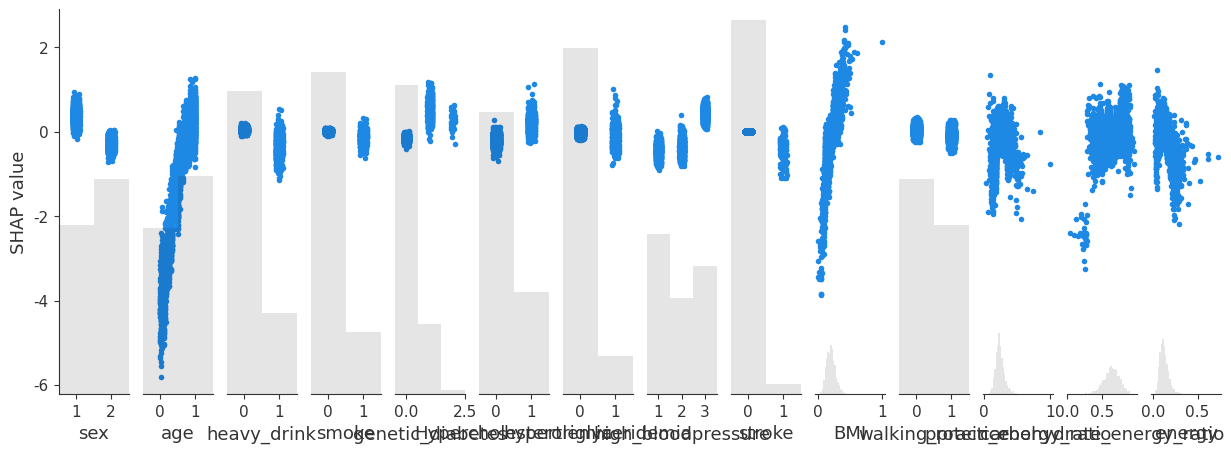

In [138]:
shap.plots.scatter(
    shap_values
)

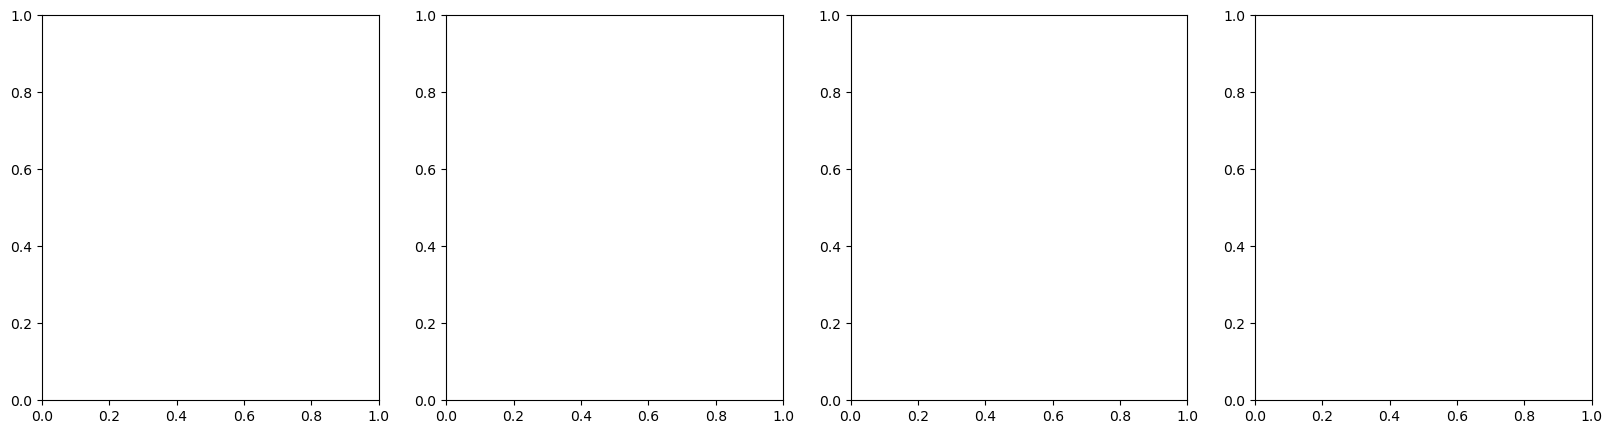

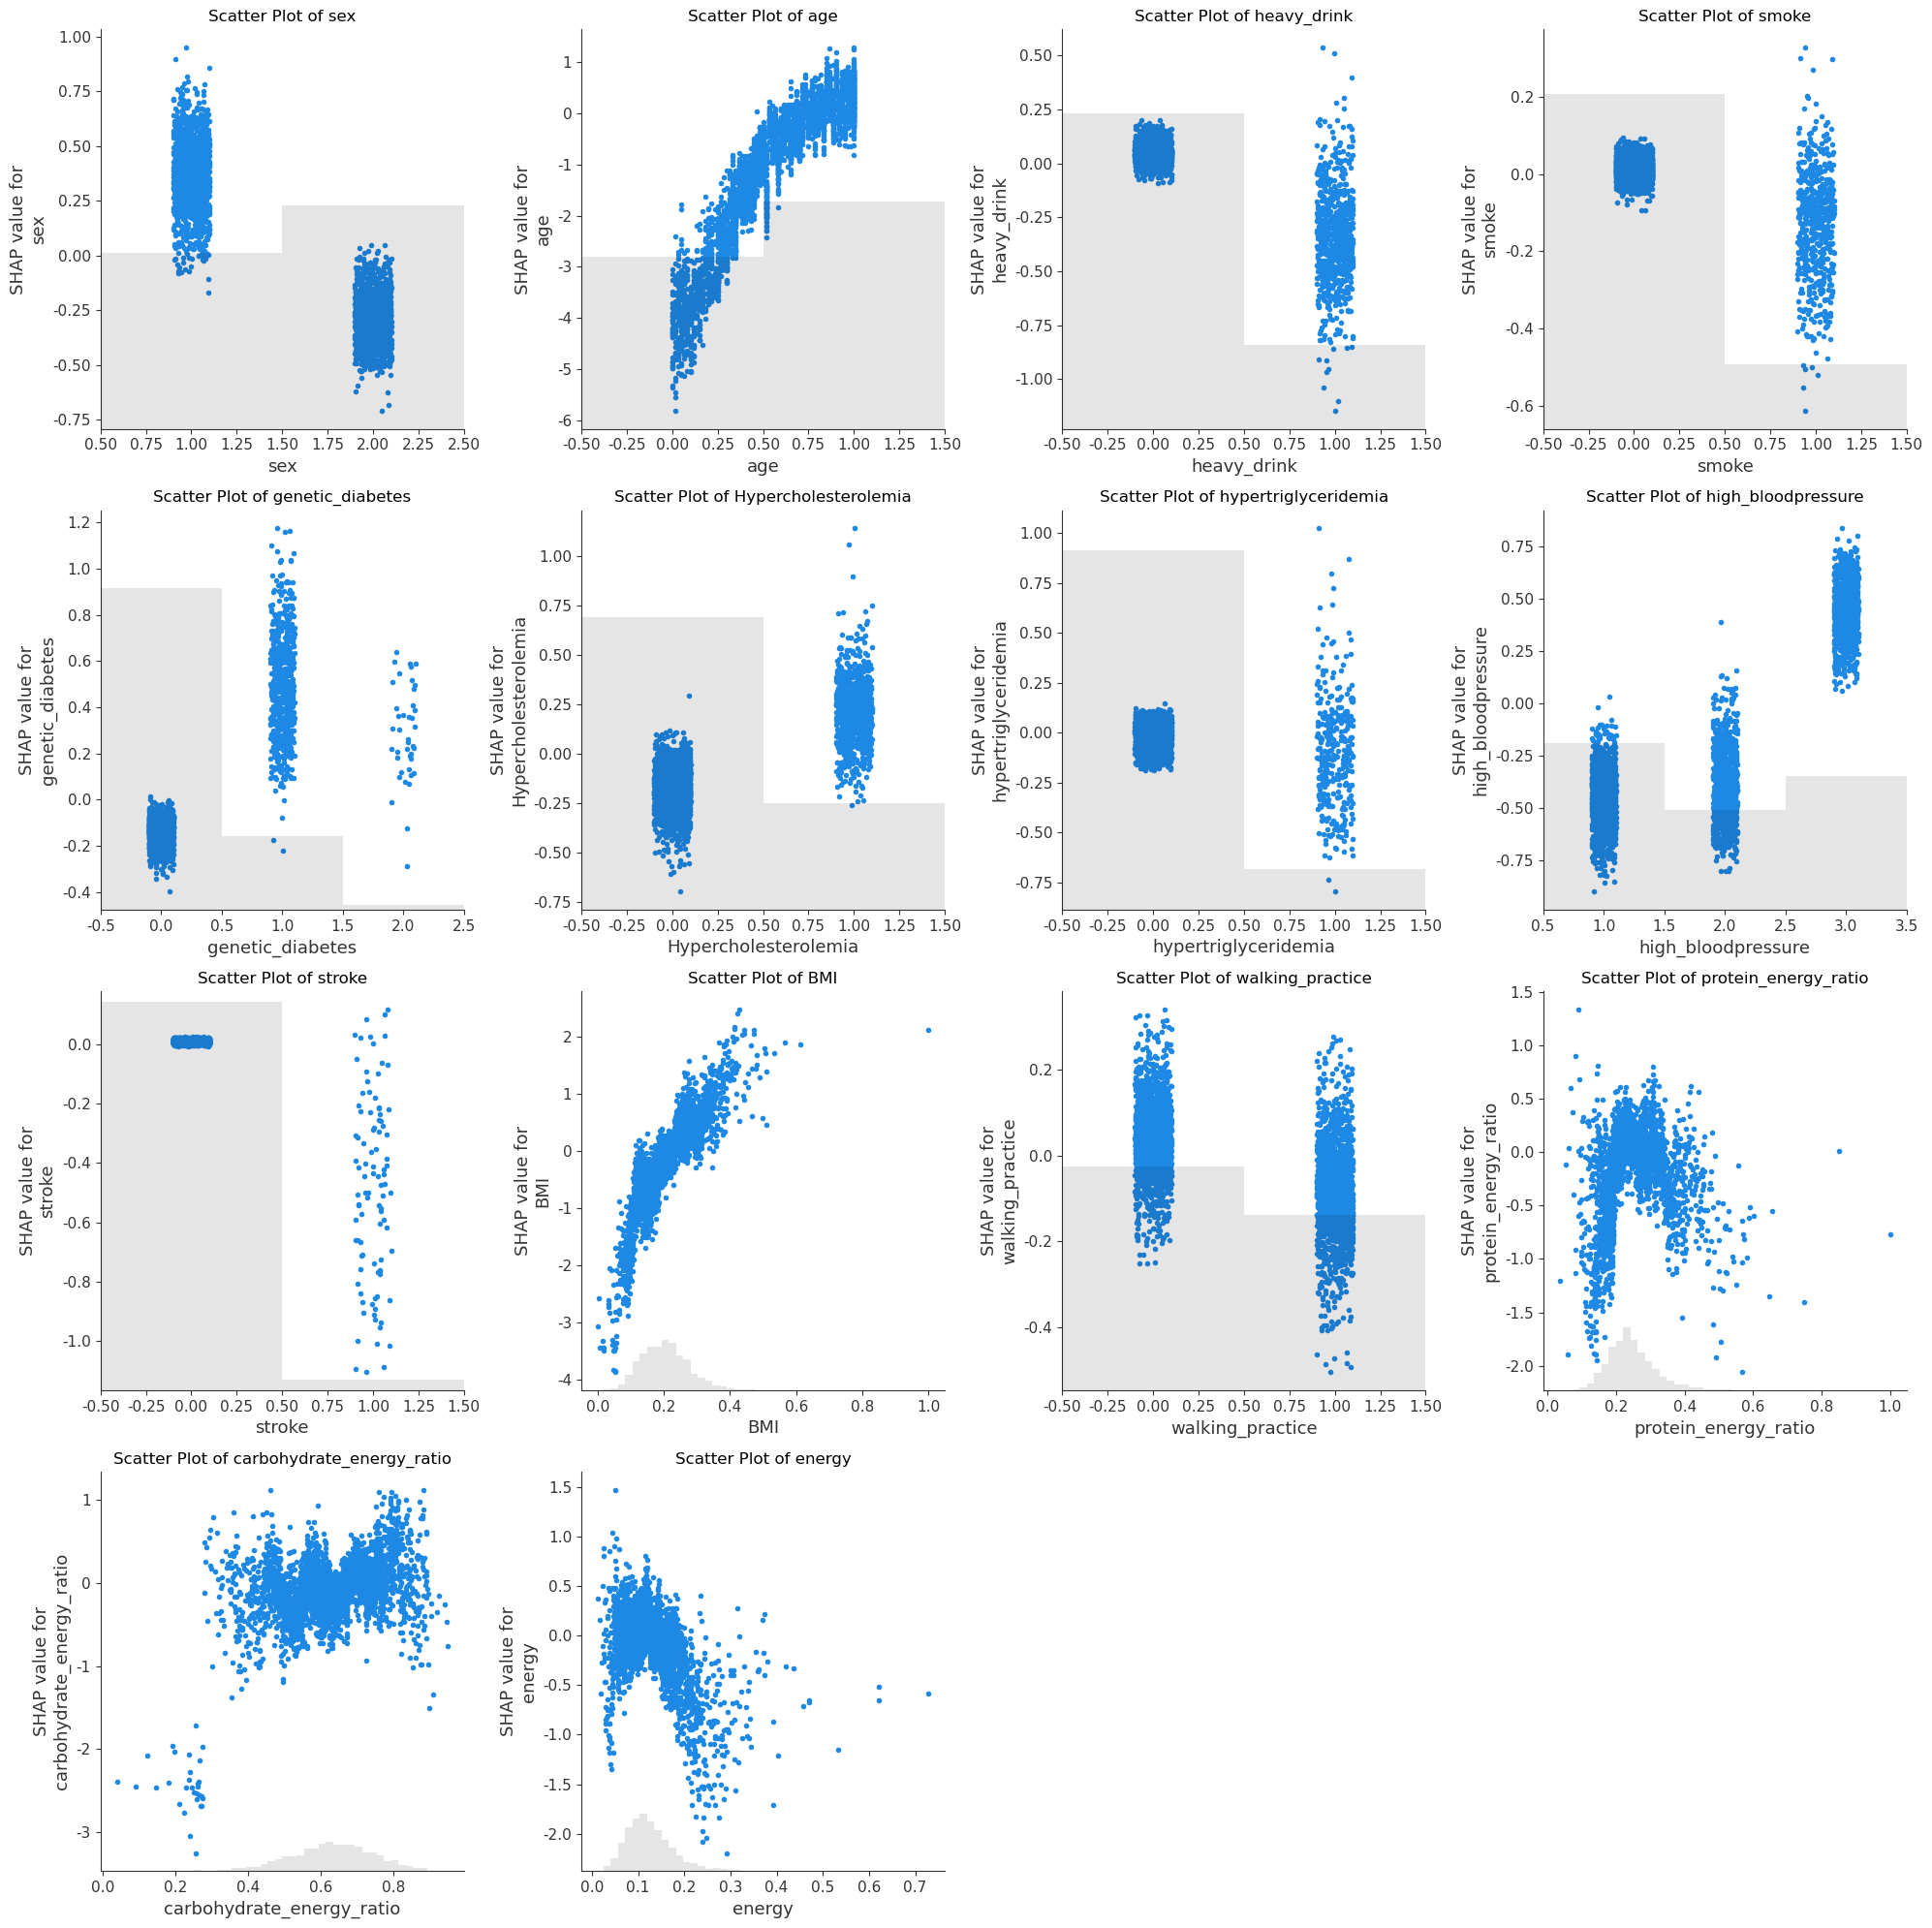

In [139]:
# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
feature_names = X_test.columns.tolist()

cols = 4  # 한 행에 4개의 그래프
rows = (len(feature_names) + cols - 1) // cols  # 필요한 행의 수 계산

# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5 * rows))

# 모든 subplot을 반복하면서 각 특성의 dependence_plot을 그립니다.
for i, feature_name in enumerate(feature_names):
    ax = axs[i // cols, i % cols]
    shap.plots.scatter(shap_values[:,feature_name], ax=ax, show=False)
    ax.set_title(f'Scatter Plot of {feature_name}')

# 사용되지 않는 subplot을 비활성화합니다.
for i in range(len(feature_names), rows * cols):
    axs[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()


In [140]:
# 개별 인스턴스에 대한 해석
# Force plot for the first instance
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test.iloc[0,:])

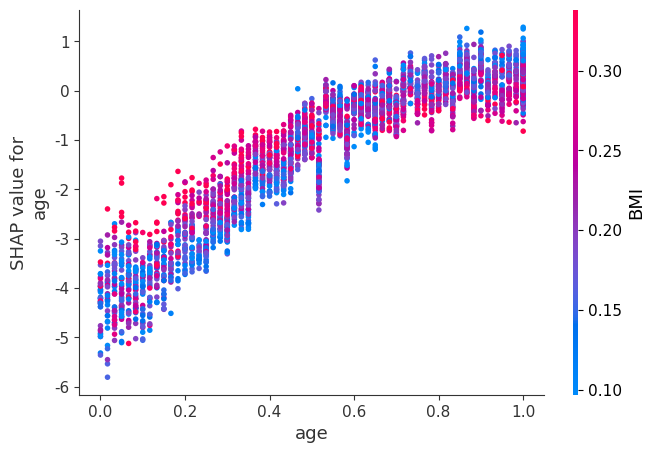

In [141]:
# 특정 피처 간의 관계에 대한 해석
shap.dependence_plot("age", shap_values.values, X_test, interaction_index="auto")

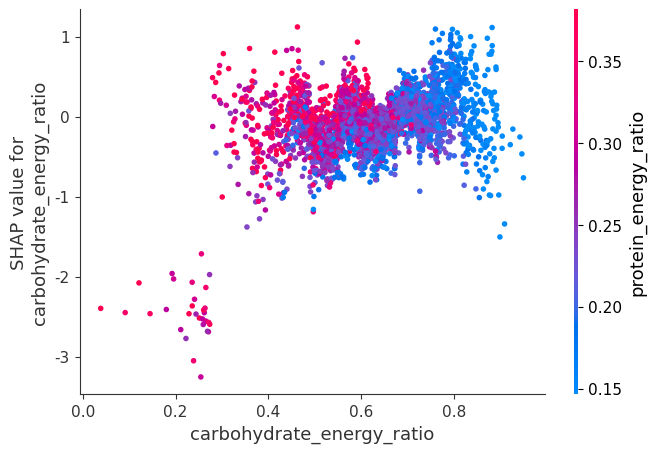

In [142]:
shap.dependence_plot("carbohydrate_energy_ratio", shap_values.values, X_test, interaction_index="auto")

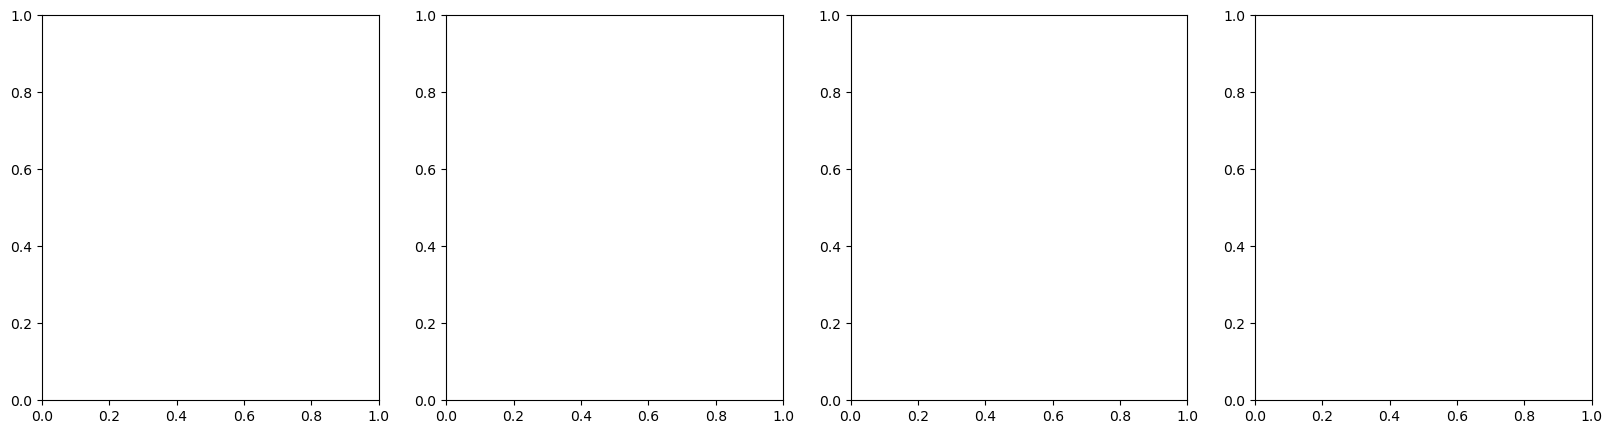

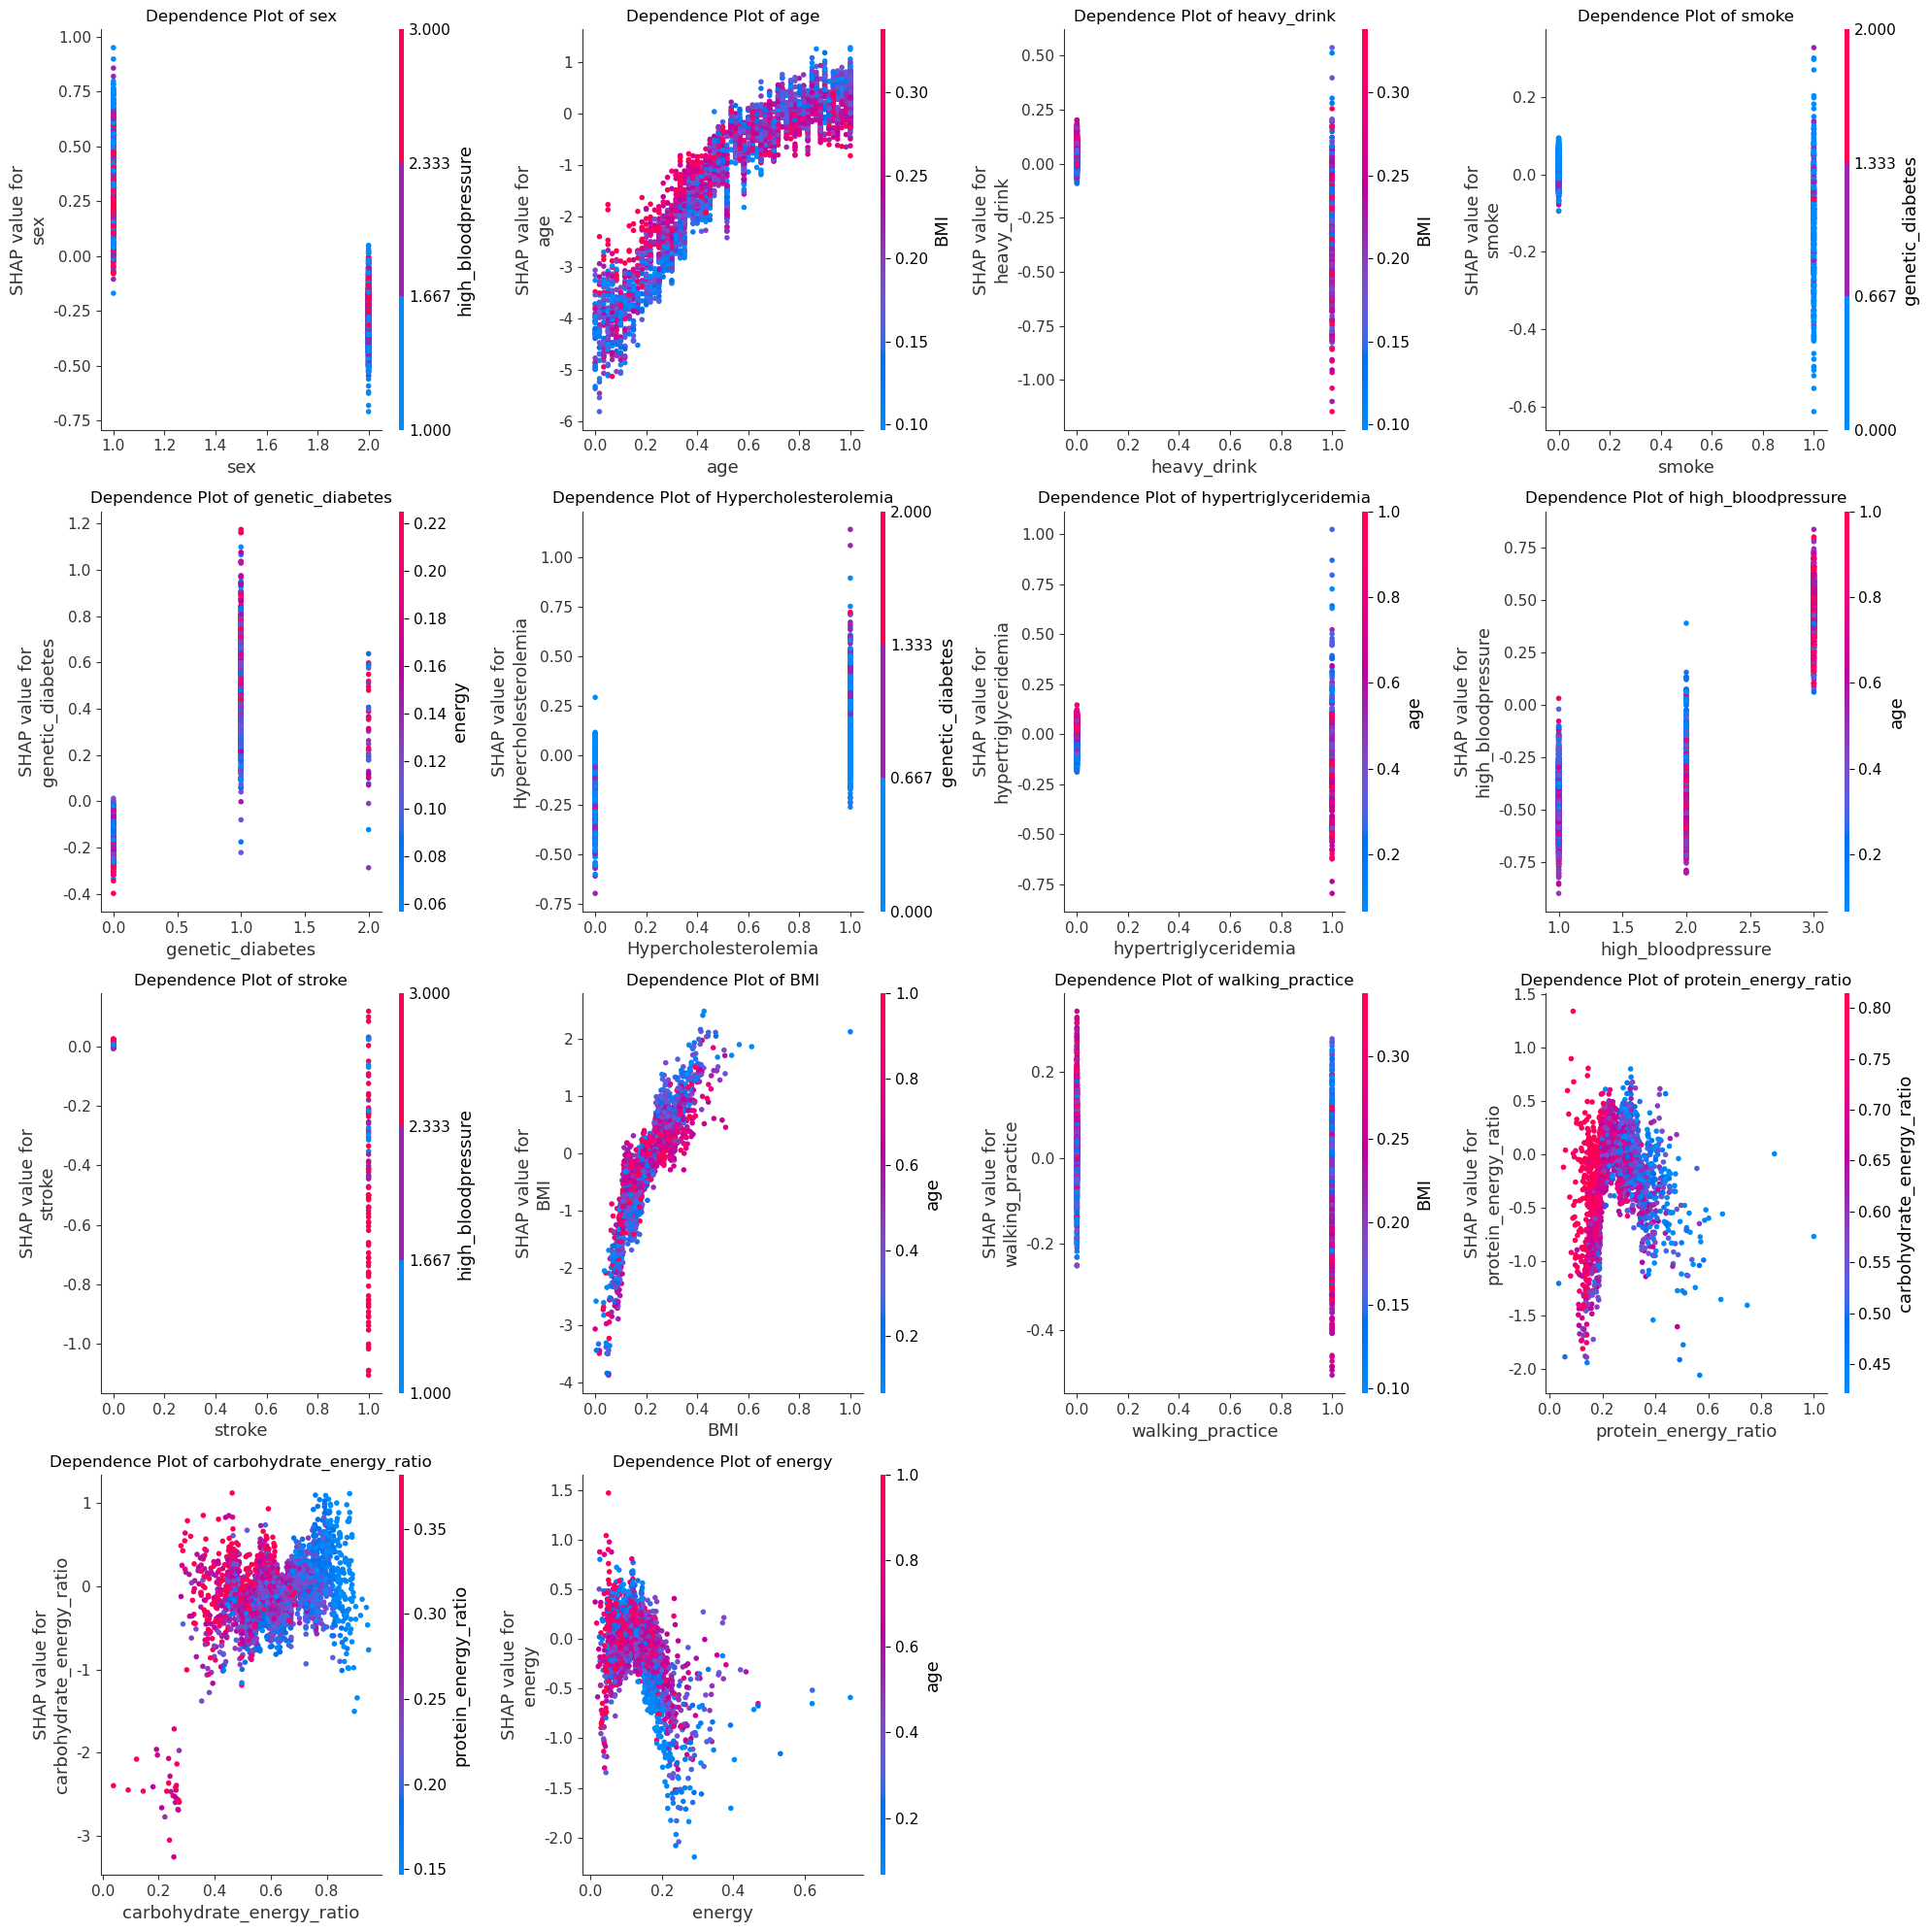

In [143]:
# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
feature_names = X_test.columns.tolist()

cols = 4  # 한 행에 4개의 그래프
rows = (len(feature_names) + cols - 1) // cols  # 필요한 행의 수 계산

# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5 * rows))

# 모든 subplot을 반복하면서 각 특성의 dependence_plot을 그립니다.
for i, feature_name in enumerate(feature_names):
    ax = axs[i // cols, i % cols]
    shap.dependence_plot(feature_name, shap_values.values, X_test, interaction_index="auto", ax=ax, show=False)
    ax.set_title(f'Dependence Plot of {feature_name}')

# 사용되지 않는 subplot을 비활성화합니다.
for i in range(len(feature_names), rows * cols):
    axs[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()


In [144]:
# # 인스턴스 수가 많아 성능저하 이슈 발생
# shap.initjs()
# shap.plots.force(shap_values)

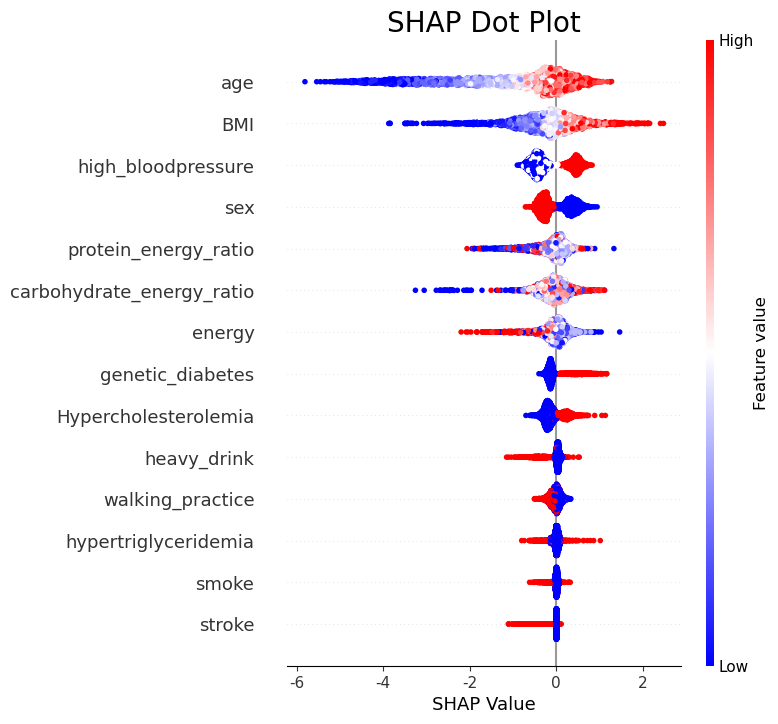

In [145]:
## Dot Plot
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_test, 
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()